In [1]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

生成数据集

In [4]:
def synthetic_data(w, b, num_examples):
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))  # 样本的各特征均服从标准正态分布，即平均值0，标准差1
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)             # 增添服从正态分布，平均值0，标准差0.01的噪声
    return X, y.reshape((-1, 1))

In [ ]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [8]:
print('features:', features[0], '\nlabel:', labels[0])

features: tensor([0.7203, 2.7050]) 
label: tensor([-3.5624])


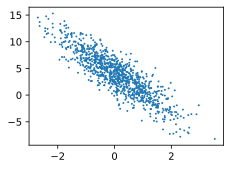

In [12]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1)

读取数据集

In [ ]:
def data_iter(batch_size, features, labels):
    """
    按照大小batch_size, 生成小批次
    每次输出一个小批次的特征数据、标签数据
    """
    num_examples = len(features)
    indices = list(range(num_examples))
    # 随机打乱样本下标读取顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i: min(i+batch_size, num_examples)]) # min防止样本数不能被批量大小整除
        yield features[batch_indices], labels[batch_indices]

In [19]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-1.7631, -0.0256],
        [-0.0769, -0.8003],
        [-0.4833,  1.3704],
        [-0.9440,  0.5068],
        [ 1.0788, -2.3284],
        [-1.7892,  0.0720],
        [ 0.6580, -0.1475],
        [-1.4986, -0.1169],
        [ 1.1554, -0.0039],
        [-0.0191,  1.2646]]) 
 tensor([[ 0.7693],
        [ 6.7644],
        [-1.4142],
        [ 0.5810],
        [14.2851],
        [ 0.3859],
        [ 6.0085],
        [ 1.5838],
        [ 6.5362],
        [-0.1195]])


In [57]:
# 初始化模型参数, 初值
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
# w = torch.zeros((2, 1), requires_grad=True) # 权重初始化为0，仍柚子O
b = torch.zeros(1, requires_grad=True)  # 偏置初始化为0

In [21]:
def linreg(X, w, b):
    """线性回归模型"""
    return torch.matmul(X, w) + b

In [22]:
def squared_loss(y_hat, y):
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

In [36]:
def sgd(params, lr, batch_size):
    """小批量随机梯度下降"""
    with torch.no_grad():  # 模型训练完后，不用计算梯度。用已算好的梯度，更新参数
        for param in params:
            param -= lr * param.grad / batch_size  # param.grad对参数张量进行原地操作，而不计算梯度，需要no_grad
            param.grad.zero_()

In [56]:
lr = 0.03           # 设置超参数学习率、迭代轮数
num_epochs = 3
net = linreg        # 设置模型为线性回归
loss = squared_loss # 设置损失函数为平方损失

In [58]:
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):  # 每次取出一个小批次
        l = loss(net(X, w, b), y)     # X和y的小批量损失
        l.sum().backward()            # l是向量，用sum()转换为标量，再计算梯度
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch+1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.046199
epoch 2, loss 0.000189
epoch 3, loss 0.000053


In [41]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([ 0.0010, -0.0015], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0006], grad_fn=<RsubBackward1>)


In [42]:
w

tensor([[ 1.9990],
        [-3.3985]], requires_grad=True)